# Recurrent Neural Networks.

- A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. (Sequential Modelling).
- These deep learning algorithms are commonly used for ordinal or temporal problems, such as language translation, natural language processing (nlp), speech recognition, and image captioning.
- They are incorporated into popular applications such as Siri, voice search, and Google Translate etc.

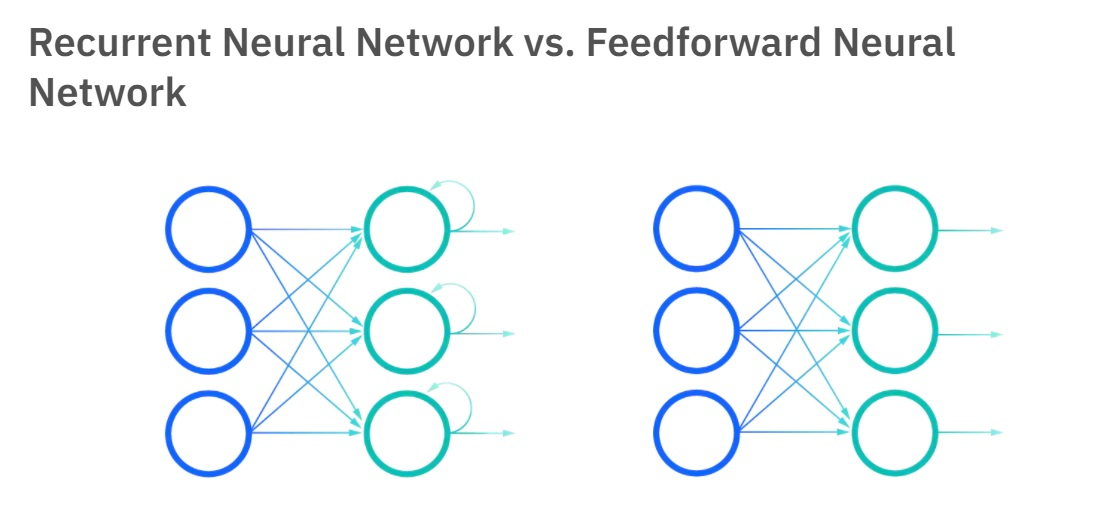

In [1]:
from IPython import display
display.Image("./rnn.jpg")

In [1]:
# standard imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import data 
df=pd.read_csv('data/data.csv',parse_dates=True,index_col='DATE')
df.head(2)

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524


In [3]:
# rename the RSCCASN column to sales 
df.columns=['Sales']
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


<AxesSubplot:xlabel='DATE'>

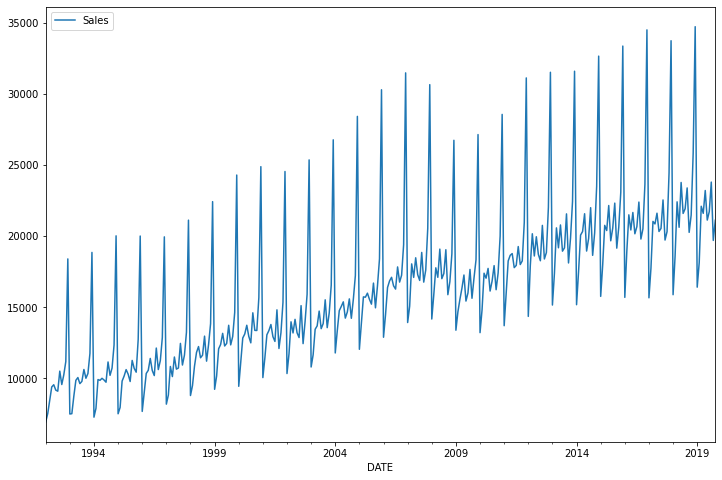

In [4]:
# plot the data 
df.plot(figsize=(12,8))

In [101]:
# check  the first and last date 

df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [69]:
#first date 1992-01-01
#last date  2019-10-01

In [5]:
#total dataframe length
len(df)

334

In [6]:
#Data is monthly, let's forecast 1.5 years into the future.
len(df)-18

316

In [7]:
# test data 
test_size = 18
test_ind = len(df)- test_size

In [8]:
# training & test data 
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.shape

(316, 1)

In [107]:
test.shape

(18, 1)

In [9]:
# scale the data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Let's redefine to get 12 months back and then predict the next month out
length = 12

# create an instance of the class and specify the input and output aspects of your time series problem (input,output,length of traning data )
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [14]:

# What does the first batch look like?
X,y = generator[1]

In [17]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.02127505 0.05580163 0.08942056 0.09512053 0.08146965 0.07860151
 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266 0.02047633]
Predict this y: 
 [[0.02127505]]


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN

In [20]:
# We're only using one feature in our time series
n_features = 1
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(100,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Stop training when a monitored metric has stopped improving
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=5)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
# fit model
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 4s 6ms/step - loss: 0.0085 - val_loss: 7.5617e-04
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 3/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 6/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0051 - val_loss: 6.6650e-04
Epoch 7/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 8/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0093 - val_loss: 0.0035
Epoch 9/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 10/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0026 - val_loss

In [47]:
losses = pd.DataFrame(model.history.history)
losses.plot()

TypeError: no numeric data to plot

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
first_eval_batch

In [ ]:
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
current_batch

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [48]:
test['Loss'] = abs(test['Sales'] - test['Predictions'])

C:\Users\user\AppData\Local\Temp/ipykernel_13328/1668801594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Loss'] = abs(test['Sales'] - test['Predictions'])


In [49]:
test.head()

,Sales,Predictions,Loss
DATE,,,
2018-05-01,23764,22059.036101,1704.963899
2018-06-01,21589,21204.830118,384.169882
2018-07-01,21919,21397.770259,521.229741
2018-08-01,23381,22721.649820,659.350180
2018-09-01,20260,20866.361944,606.361944


In [50]:
sum(test['Loss'])

18786.54599380494

<AxesSubplot:xlabel='DATE'>

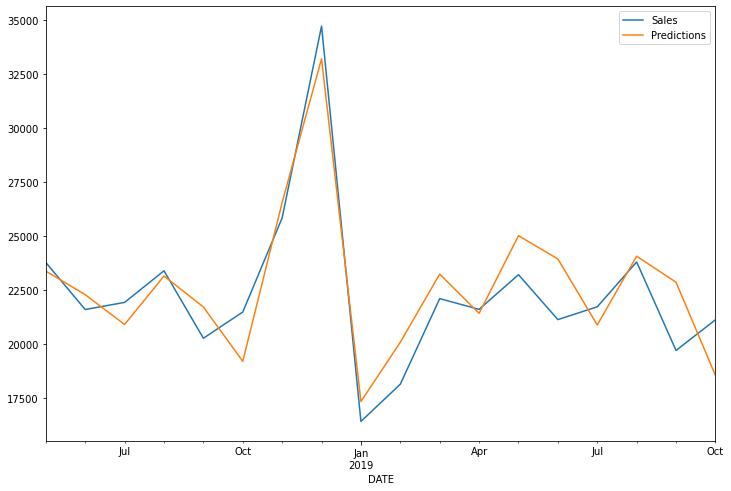

In [31]:
test.plot(figsize=(12,8))

- This kind of RNN suffered from the problem of <b>vanishing & exploding gradients </b>hence unable to model long term dependencies.
- Therefore, LSTM and GRU were developed to solve the problem with traditional RNNS.
- There two architecture use mechanisms known as <b>Gates</b>

In [32]:
#model
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [33]:
# We're only using one feature in our time series
n_features = 1

In [53]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [55]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [56]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [57]:
# fit model
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 6s 13ms/step - loss: 0.0222 - val_loss: 0.0383
Epoch 2/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0156 - val_loss: 0.0018
Epoch 3/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0083 - val_loss: 6.4305e-04
Epoch 4/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 5/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0034 - val_loss: 4.4851e-04
Epoch 6/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 0.0022


In [58]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

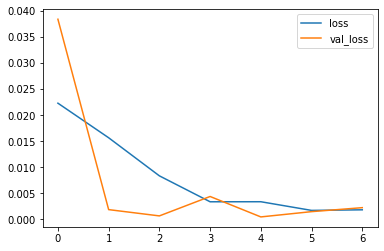

In [59]:
losses.plot()

Evaluate on Test Data¶


In [60]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [61]:
true_predictions = scaler.inverse_transform(test_predictions)

In [62]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\user\AppData\Local\Temp/ipykernel_13328/1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [63]:
test['Loss'] = abs(test['Sales'] - test['Predictions'])

C:\Users\user\AppData\Local\Temp/ipykernel_13328/1668801594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Loss'] = abs(test['Sales'] - test['Predictions'])


In [64]:
sum(test['Loss'])

13828.591775655741

In [65]:
test.head()

,Sales,Predictions,Loss
DATE,,,
2018-05-01,23764,22328.668968,1435.331032
2018-06-01,21589,21003.999725,585.000275
2018-07-01,21919,21299.431056,619.568944
2018-08-01,23381,23372.106378,8.893622
2018-09-01,20260,20638.744752,378.744752


<AxesSubplot:xlabel='DATE'>

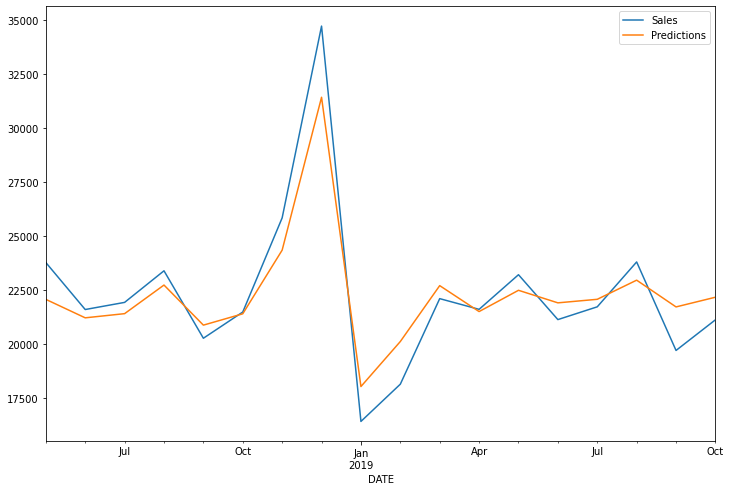

In [46]:
test.plot(figsize=(12,8))

In [66]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [67]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [69]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
#model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit(generator,epochs=8)


Epoch 1/8
322/322 [==============================] - 5s 9ms/step - loss: 0.0253
Epoch 2/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0173
Epoch 3/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0093
Epoch 4/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0049
Epoch 5/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0043
Epoch 6/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0025
Epoch 7/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0021
Epoch 8/8
322/322 [==============================] - 4s 14ms/step - loss: 0.0017


In [70]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [71]:
forecast = scaler.inverse_transform(forecast)

In [72]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [73]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [74]:
forecast_df

,Forecast
2019-11-01,25168.365121
2019-12-01,35455.485712
2020-01-01,16429.184431
2020-02-01,17843.125490
2020-03-01,21259.669505
2020-04-01,20806.589097
2020-05-01,22307.098010
2020-06-01,20397.206338
2020-07-01,20986.336133
2020-08-01,22924.916571


<AxesSubplot:>

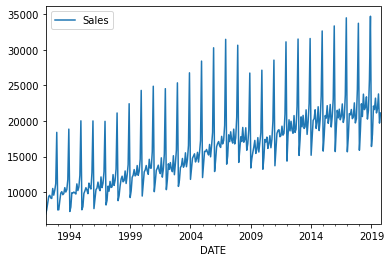

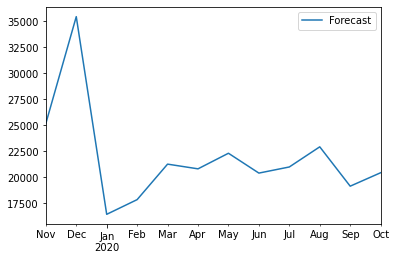

In [75]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

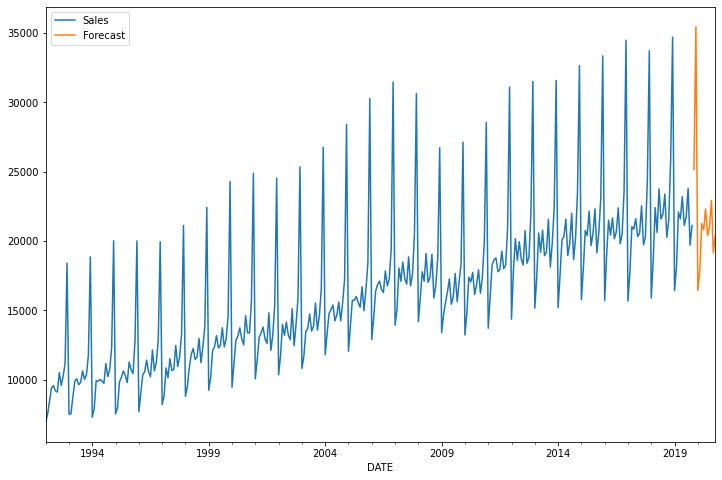

In [76]:
ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)

(576.0, 611.0)

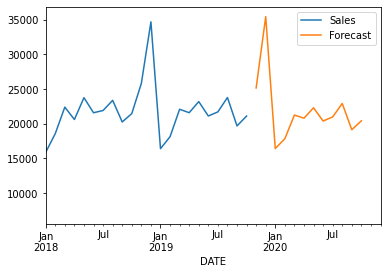

In [77]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# END